# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025


In [10]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import gammaln

ERROR! Session/line number was not unique in database. History logging moved to new session 419


**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell before you submit.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 10, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } k\,n \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

*Hint*: In all of the exercises below, use rates that are possible biologically, especially for $s$ and $k$ (see course). Note that the units here are in minutes.

#### Question 1
1. Using the code template provided, which includes initial values and parameters, modify the Gillespie algorithm to simulate the Telegraph model. Focus on integrating the two-state model for the promoter accurately into the algorithm.

2. Explore several simulations where you vary the rates (e.g increase or decrease $k$, $s$, $k_{on}$, $k_{off}$), plot *three* representative examples with different rates and comment. Find cases that show qualitatively different behaviors. For each case, report the coefficient of variation of the number of mRNA copies ($CV=\frac{\sigma}{\mu}$). *Hint*: always show simulations of length at about 10-20 times $k^{-1}$.

#### Gillespie template

In [11]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1:  # Promoter is active
            # Reactions: production, degradation, switching off
            S = np.array([
                [0, 1],    # Production: g unchanged, n increases by 1
                [0, -1],   # Degradation: g unchanged, n decreases by 1
                [-1, 0]    # Switch off: g becomes 0, n unchanged
            ])
            rates = np.array([
                s,           # Production rate
                k * n,       # Degradation rate
                k_off        # Rate of switching off
            ])
        else:  # Promoter is inactive
            # Reactions: degradation, switching on
            S = np.array([
                [0, -1],   # Degradation: g unchanged, n decreases by 1
                [1, 0]     # Switch on: g becomes 1, n unchanged
            ])
            rates = np.array([
                k * n,      # Degradation rate
                k_on        # Rate of switching on
            ])

        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

In [12]:
def plot_gillespie_telegraph(n, g, t):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=np.min(g), ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(np.min(g), np.max(g)+0.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Common x-label
    plt.xlabel('time [min]')
    
    plt.show()

In [13]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate, 1/k = 50 min
k_off = 1/15 #Switching off rate, t_on = 1/k_off
k_on  = 1/120 #Switching on rate, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)
print(f"Pon:{p_on}") 

n_expected = s/k * p_on
# convert to integer
n_0 = int(n_expected)

t_end = 20 * 1/k # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

Pon:0.1111111111111111


#### Q1.2

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

def analyze_telegraph_distribution(n0, g0, parameters, t_end, DT, n_simulations=1000):
    """
    Analyzes the distribution of mRNA numbers from multiple telegraph model simulations.
    
    Parameters:
    n0, g0, parameters, t_end, DT: Parameters for run_gillespie_telegraph
    n_simulations: Number of simulations to run
    
    Returns:
    np.array: Array of mRNA counts sampled at steady state
    """
    # Skip initial transient by only keeping last quarter of simulation
    steady_state_start = int(0.75 * (t_end/DT))
    
    # Store mRNA counts from all simulations
    all_counts = []
    
    for _ in range(n_simulations):
        n, g, t = run_gillespie_telegraph(n0, g0, parameters, t_end, DT)
        # Take samples from steady state
        steady_state_counts = n[steady_state_start:]
        all_counts.extend(steady_state_counts)
    
    return np.array(all_counts)

# Parameters for Poisson-like behavior
# Fast switching rates compared to transcription/degradation
s = 1.0      # transcription rate
k = 0.02     # degradation rate
k_on = 2.0   # fast switching on
k_off = 0.5  # fast switching on
parameters_poisson = [s, k, k_on, k_off]

# Parameters for bimodal behavior
# Slow switching rates compared to transcription/degradation
s_bimodal = 5.0     # high transcription rate
k_bimodal = 0.02    # same degradation rate
k_on_bimodal = 0.01  # slow switching
k_off_bimodal = 0.01 # slow switching
parameters_bimodal = [s_bimodal, k_bimodal, k_on_bimodal, k_off_bimodal]

# Run simulations for both parameter sets
t_end = 2000  # Long enough to reach steady state
DT = 0.1

# Initial conditions
g0 = 1  # Start with active promoter
n0 = int((s/k) * (k_on/(k_on + k_off)))  # Expected steady state

# Simulate Poisson-like case
counts_poisson = analyze_telegraph_distribution(n0, g0, parameters_poisson, t_end, DT)

# Calculate theoretical Poisson distribution
lambda_poisson = np.mean(counts_poisson)
x_poisson = np.arange(0, max(counts_poisson) + 1)
poisson_pmf = np.exp(x_poisson * np.log(lambda_poisson) - lambda_poisson - gammaln(x_poisson + 1))

# Simulate bimodal case
counts_bimodal = analyze_telegraph_distribution(n0, g0, parameters_bimodal, t_end, DT)



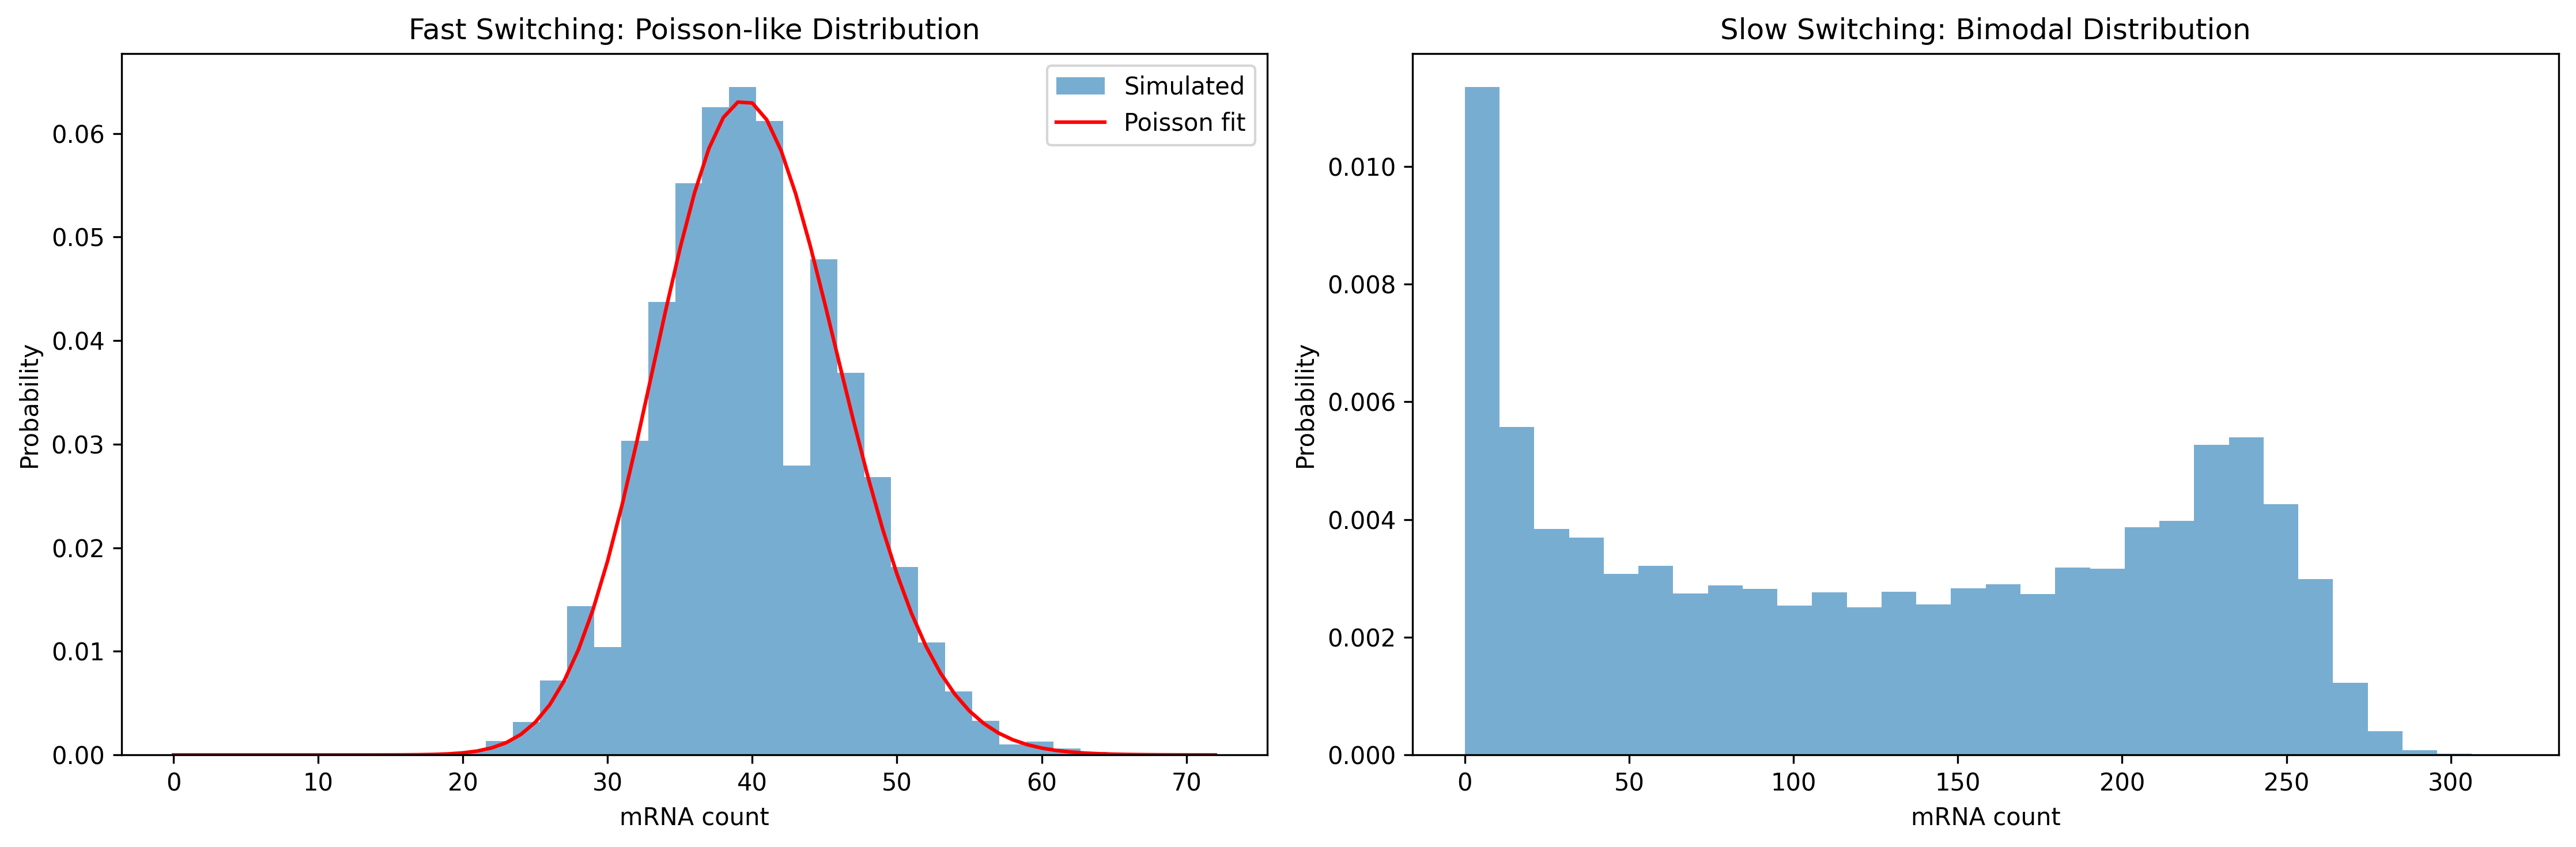

Poisson-like case CV: 0.164
Bimodal case CV: 0.694


In [15]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

# Plot Poisson-like distribution
ax1.hist(counts_poisson, bins=30, density=True, alpha=0.6, label='Simulated')
ax1.plot(x_poisson, poisson_pmf, 'r-', label='Poisson fit')
ax1.set_title('Fast Switching: Poisson-like Distribution')
ax1.set_xlabel('mRNA count')
ax1.set_ylabel('Probability')
ax1.legend()

# Plot bimodal distribution
ax2.hist(counts_bimodal, bins=30, density=True, alpha=0.6)
ax2.set_title('Slow Switching: Bimodal Distribution')
ax2.set_xlabel('mRNA count')
ax2.set_ylabel('Probability')

plt.tight_layout()
plt.show()

# Calculate coefficient of variation
cv_poisson = np.std(counts_poisson) / np.mean(counts_poisson)
cv_bimodal = np.std(counts_bimodal) / np.mean(counts_bimodal)

print(f"Poisson-like case CV: {cv_poisson:.3f}")
print(f"Bimodal case CV: {cv_bimodal:.3f}")

#### Question 2
1. Study the distribution of mRNA numbers generated by your simulations. Identify parameters that results in a Poisson distribution of mRNA numbers. Show the empiral histogram and overlay an exact Poisson distribution. In this regime, explain how the parameters of the Telegraph model relate to the parameter of the Poisson distribution. *Hint*: $k_{off}=0$ with $g(t=0)=1$ is not the right answer. 

2. Find parameters where the mRNA distribution deviates from the Poisson. *Hint*: Look for a regime that yields a bimodal distribution. Explain your reasoning.

####  Helper functions for the Poisson distribution

In [16]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

#### Q2.1

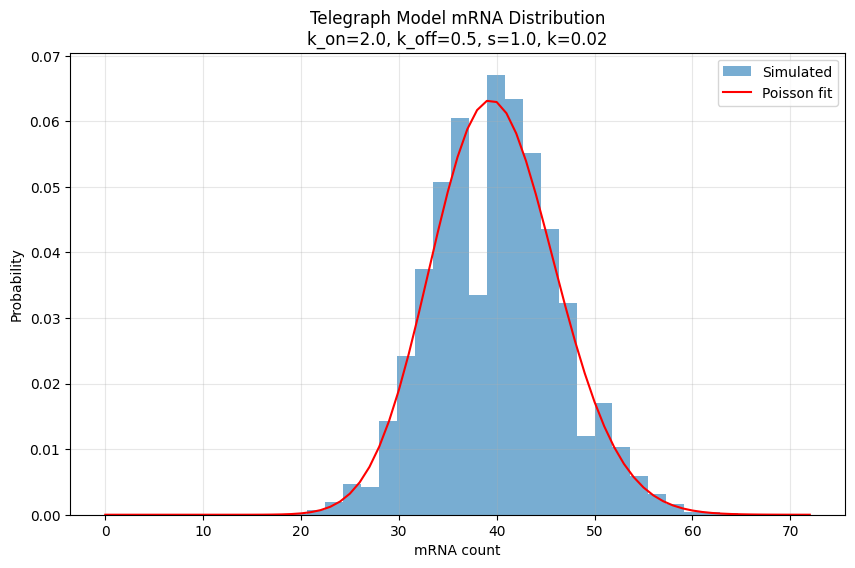

Coefficient of variation: 0.162
Mean mRNA count: 39.9
Expected mean from theory: 40.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

def analyze_telegraph_distribution(n0, g0, parameters, t_end, DT, n_simulations=1000):
    """
    Analyzes the distribution of mRNA numbers from multiple telegraph model simulations.
    
    Parameters:
    n0, g0, parameters, t_end, DT: Parameters for run_gillespie_telegraph
    n_simulations: Number of simulations to run
    
    Returns:
    np.array: Array of mRNA counts sampled at steady state
    """
    # Skip initial transient by only keeping last quarter of simulation
    steady_state_start = int(0.75 * (t_end/DT))
    
    # Store mRNA counts from all simulations
    all_counts = []
    
    for _ in range(n_simulations):
        n, g, t = run_gillespie_telegraph(n0, g0, parameters, t_end, DT)
        # Take samples from steady state
        steady_state_counts = n[steady_state_start:]
        all_counts.extend(steady_state_counts)
    
    return np.array(all_counts)

# Parameters for Poisson-like behavior
s = 1.0      # transcription rate
k = 0.02     # degradation rate
k_on = 2.0   # fast switching on - much faster than transcription
k_off = 0.5  # fast switching off - still faster than transcription/degradation
parameters_poisson = [s, k, k_on, k_off]

# Initial conditions
g0 = 1  # Start with active promoter
n0 = int((s/k) * (k_on/(k_on + k_off)))  # Expected steady state

# Simulation parameters
t_end = 2000  # Long enough to reach steady state
DT = 0.1

# Run simulation and collect steady-state samples
counts = analyze_telegraph_distribution(n0, g0, parameters_poisson, t_end, DT)

# Calculate theoretical Poisson distribution
lambda_poisson = np.mean(counts)  # Use empirical mean as Poisson parameter
x = np.arange(0, max(counts) + 1)
poisson_pmf = np.exp(x * np.log(lambda_poisson) - lambda_poisson - gammaln(x + 1))

# Plot results
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, density=True, alpha=0.6, label='Simulated')
plt.plot(x, poisson_pmf, 'r-', label='Poisson fit')
plt.title('Telegraph Model mRNA Distribution\n' + 
          f'k_on={k_on}, k_off={k_off}, s={s}, k={k}')
plt.xlabel('mRNA count')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate coefficient of variation
cv = np.std(counts) / np.mean(counts)
print(f"Coefficient of variation: {cv:.3f}")
print(f"Mean mRNA count: {np.mean(counts):.1f}")
print(f"Expected mean from theory: {(s/k) * (k_on/(k_on + k_off)):.1f}")

#### Q2.2

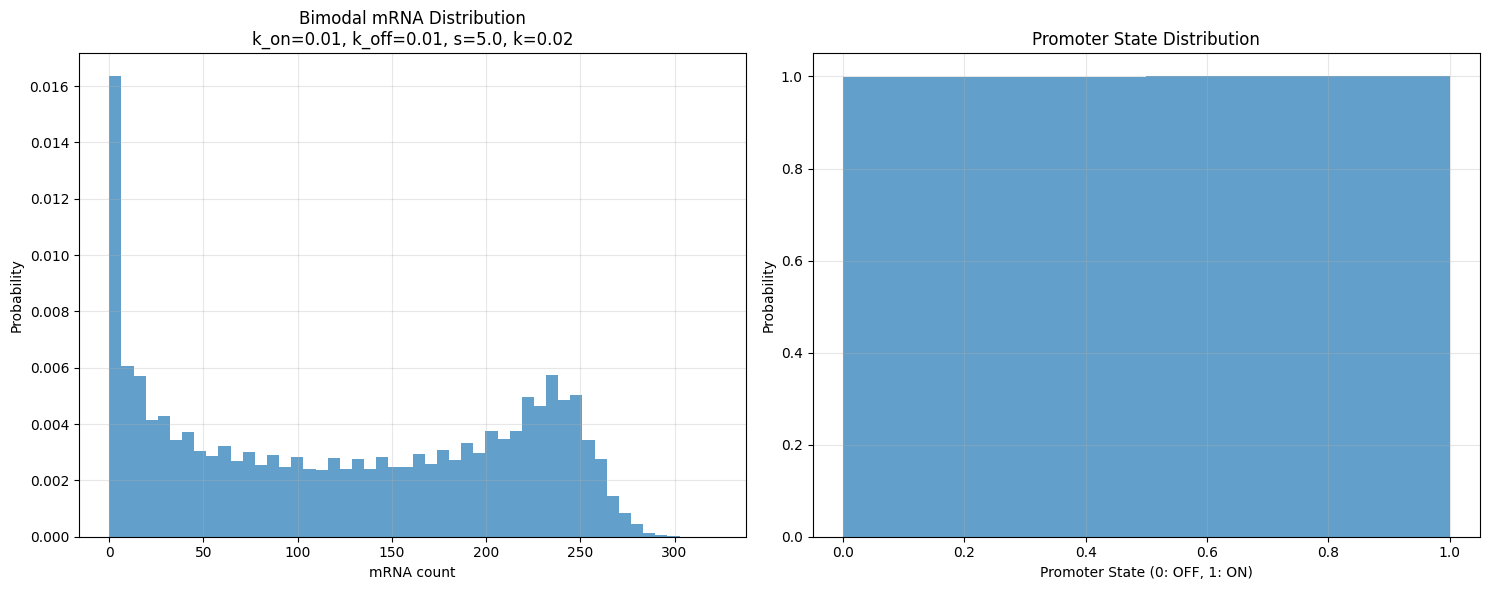

Coefficient of variation: 0.713
Mean mRNA count: 125.0
Fraction of time promoter is ON: 0.500
Expected theoretical fraction ON: 0.500


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_telegraph_bimodal(n0, g0, parameters_bimodal, t_end, DT, n_simulations=1000):
    """
    Analyzes the bimodal distribution of mRNA numbers from telegraph model simulations.
    
    Parameters:
    n0, g0, parameters_bimodal, t_end, DT: Parameters for run_gillespie_telegraph
    n_simulations: Number of simulations to run
    
    Returns:
    np.array: Array of mRNA counts and promoter states sampled at steady state
    """
    # Skip initial transient
    steady_state_start = int(0.75 * (t_end/DT))
    
    # Store counts and states
    all_counts = []
    all_states = []
    
    for _ in range(n_simulations):
        n, g, t = run_gillespie_telegraph(n0, g0, parameters_bimodal, t_end, DT)
        steady_state_counts = n[steady_state_start:]
        steady_state_g = g[steady_state_start:]
        all_counts.extend(steady_state_counts)
        all_states.extend(steady_state_g)
    
    return np.array(all_counts), np.array(all_states)

# Parameters for bimodal behavior
s = 5.0       # High transcription rate when ON
k = 0.02      # Same degradation rate as before
k_on = 0.01   # Slow switching on
k_off = 0.01  # Slow switching off
parameters_bimodal = [s, k, k_on, k_off]

# Initial conditions
g0 = 1  # Start with active promoter
n0 = int((s/k) * (k_on/(k_on + k_off)))  # Expected steady state

# Simulation parameters
t_end = 5000  # Longer simulation to ensure steady state
DT = 0.1

# Run simulation
counts, states = analyze_telegraph_bimodal(n0, g0, parameters_bimodal, t_end, DT)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot mRNA distribution
ax1.hist(counts, bins=50, density=True, alpha=0.7)
ax1.set_title('Bimodal mRNA Distribution\n' + 
              f'k_on={k_on}, k_off={k_off}, s={s}, k={k}')
ax1.set_xlabel('mRNA count')
ax1.set_ylabel('Probability')
ax1.grid(True, alpha=0.3)

# Plot promoter state distribution
ax2.hist(states, bins=2, density=True, alpha=0.7)
ax2.set_title('Promoter State Distribution')
ax2.set_xlabel('Promoter State (0: OFF, 1: ON)')
ax2.set_ylabel('Probability')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistics
cv = np.std(counts) / np.mean(counts)
mean_count = np.mean(counts)
fraction_on = np.mean(states)

print(f"Coefficient of variation: {cv:.3f}")
print(f"Mean mRNA count: {mean_count:.1f}")
print(f"Fraction of time promoter is ON: {fraction_on:.3f}")
print(f"Expected theoretical fraction ON: {k_on/(k_on + k_off):.3f}")

#### Question 3 (Promoter cycle)
Transcription in mammals often requires a more complicated telegraph model (promoter cycle), where the promoter state goes through an $ON$ state, and then sequentially goes through several $OFF_n$ state before returning to the ON state. For example with two $OFF$ states, it would look like: $ON\,(g=1)\longrightarrow OFF_1 (g=2) \longrightarrow OFF_2 (g=3) \longrightarrow ON (g=1)$. This is related to the fact that transcription events often show a refractory period, *i.e.* promoter tend to stay off for some amount of time before turning back on. 

1. Modify the above code to implement the promoter cycle with two $OFF$ state. First, use rates as in the example above with the following modifications: $s = 20$, $k = 0.02$, $k_{on-off_1} = 1/15$, $k_{off_1-off_2} = 1/60$ and $k_{off_2-on}  = 1/60$. Show some representative simulations. Plot both the mRNA and promoter state.

2. Study the distribution of the durations of each $OFF$ interval separately and of the two $OFF$ intervals together. Focus on the shape of the distributions. Explain your findings.

3. (Bonus). Can you explain mathematically the shape of the distribution? What would happen if you include more $OFF_n$ states?

In [ ]:
#Adapt the Gillepsie algorithm to the promoter cycle case